<a href="https://colab.research.google.com/github/thissop/MAXI-J1535/blob/main/code/machine-learning/December-%202021-2022/april_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# april 23

## Notes


In [11]:
!pip install rebin
!pip install shap
import shap
import graphviz
from rebin import rebin 
import pandas as pd
import sklearn
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import median_absolute_error as mae_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import r2_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn import utils 
from sklearn.model_selection import KFold, StratifiedKFold

plt.style.use('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/stolen_science.mplstyle?token=GHSAT0AAAAAABP54PQO2X2VXMNS256IWOBOYRNCFBA')

rs = 4

     |████████████████████████████████| 564 kB 3.9 MB/s 


In [6]:
import pickle

rebin_dict = {}

with open('/content/rebin_data_dict_25.pickle', 'rb') as handle: 
    rebin_dict = pickle.load(handle)

## misc

In [32]:
# methods

def norm(x, min, max): 
    return (x - min) / (max - min)

def unnorm(x, min, max):
    return x*(max-min)+min

def get_plot(id: str): 
    from PIL import Image
    import requests

    url = 'https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/xspec_related/qpo_routines/full_aggregation/plot_dists/quad-panels/'
    url += id + '.png'
    im = Image.open(requests.get(url, stream=True).raw)

    return im

def run_grid_search(grid, X, y, n_splits: int = 10, model: str = 'randomforest'): 
    import numpy as np
    from sklearn.model_selection import StratifiedKFold
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    
    skf = StratifiedKFold(n_splits=n_splits)

    if model=='randomforest': 

        grid_dict = {'n_estimators':[50, 100, 500, 1000],
                'min_samples_split':[2,4,6,8],
                'min_samples_leaf':[1,2,3]}

        keys = grid_dict.keys()
        grid_matrix = []
        grid_scores = []
        for i in grid_dict[keys[0]]: 
            for j in grid_dict[keys[1]]: 
                for k in grid_dict[keys[2]]: 
                    combination = [i,j,k]
                    grid_matrix.append(combination)

        for combination in grid_matrix: 
            scores = []
            for train_index, test_index in skf.split(X, y):

                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                regr = RandomForestRegressor(n_estimators=combination[0], 
                                             min_samples_split=combination[1], 
                                             min_samples_leaf=combination[2])
                regr.fit(X_train,y_train)

                predictions = regr.predict(X_test)
                
                score = regr.score(y_test, predictions)
                scores.append(score)
            
            grid_scores.append(np.mean(scores))
    
        return grid_matrix, grid_scores

    elif model=='linear':
        scores = []
        for train_index, test_index in skf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            regr = LinearRegression()
            regr.fit(X_train,y_train)

            predictions = regr.predict(X_test)
            
            score = regr.score(y_test, predictions)
            scores.append(score)

        return scores, np.mean(scores)

# best routine

### spectral

In [76]:
qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/new_current_qpos.csv').fillna(0)

mask = np.where(np.isfinite(qpo_df['num_qpos']))

qpo_df = qpo_df.iloc[mask]

for i in ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']: 
    qpo_df = qpo_df.astype({i:float})

for i, j in zip(qpo_df['full_id'], rebin_dict['rebin_counts'].keys()): 
    if i!=j: 

        print('mis-match')
        print(i,j)

full_ids = np.array(qpo_df['full_id'])

In [77]:
# get masks 

all_confidences = np.array(qpo_df['confidence_class'])
train_mask = np.logical_and(all_confidences<3, all_confidences>-1)
non_zero_mask = np.logical_and(qpo_df['num_qpos']>0, train_mask)
bad_test_mask = np.logical_or(all_confidences==3, all_confidences==4)
third_mask = np.where(all_confidences==3)
fourth_mask = np.where(all_confidences==4)

In [78]:
# package x values
x_vals = np.array(list(rebin_dict['rebin_counts'].values()), dtype=float)

# package y values

combined_freqs = np.concatenate((qpo_df['first_freq'], qpo_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((qpo_df['first_width'], qpo_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((qpo_df['first_norm'], qpo_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'third_freq']
freq1s, freq2s, freq3s = (norm(np.array(qpo_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names)

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], freq3s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)

In [79]:
X_train = x_vals[train_mask]
y_train = y_vals[train_mask]

X_train_no_zero = x_vals[non_zero_mask]
y_train_no_zero = y_vals[non_zero_mask]

[Text(0, 0.5, 'Predicted Frequency'), Text(0.5, 0, 'True Frequency')]

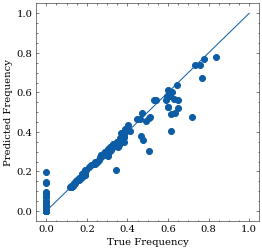

In [80]:
regr = RandomForestRegressor()
regr.fit(X_train,y_train)

regr.score(X_train, y_train)

fig, ax = plt.subplots(figsize=(4,4))

predictions = regr.predict(X_train)

ax.scatter(y_train, predictions)
ax.plot((0,1), (0,1))

ax.set(xlabel='True Frequency', ylabel='Predicted Frequency')

In [85]:
def return_bad_ids(predictions=predictions, true=y_train, test_ids=full_ids, cutoff: float = 0.05, true_zero: bool = True): 
    
    bad_ids = []
    index = 0
    for pred_cell, true_cell in zip(predictions, true): 
        for i, j in zip(pred_cell, true_cell): 
            if np.abs(i-j)>cutoff: 

                if true_zero: 
                    if j == 0: 
                        bad_ids.append(test_ids[index])
                        print(test_ids[index], unnorm(true_cell, min_freq, max_freq), unnorm(pred_cell, min_freq, max_freq))

                else: 
                    bad_ids.append(test_ids[index])

        index += 1

    return bad_ids

bad_ids = return_bad_ids()

1050360103_0 [0. 0. 0.] [1.40624188 1.01455668 0.        ]
1050360103_0 [0. 0. 0.] [1.40624188 1.01455668 0.        ]
1050360110_4 [0. 0. 0.] [2.08911327 0.         0.        ]
1050360111_2 [0. 0. 0.] [2.87414906 0.         0.        ]
1050360118_4 [0. 0. 0.] [0.73128581 1.29052701 0.        ]
1050360119_4 [6.84915628 0.         0.        ] [5.57640447 2.13213706 0.        ]
1130360103_0 [0. 0. 0.] [1.07950558 0.10537894 0.        ]
1130360105_0 [0. 0. 0.] [1.06108738 0.         0.        ]


In [65]:
from IPython.display import Image, display

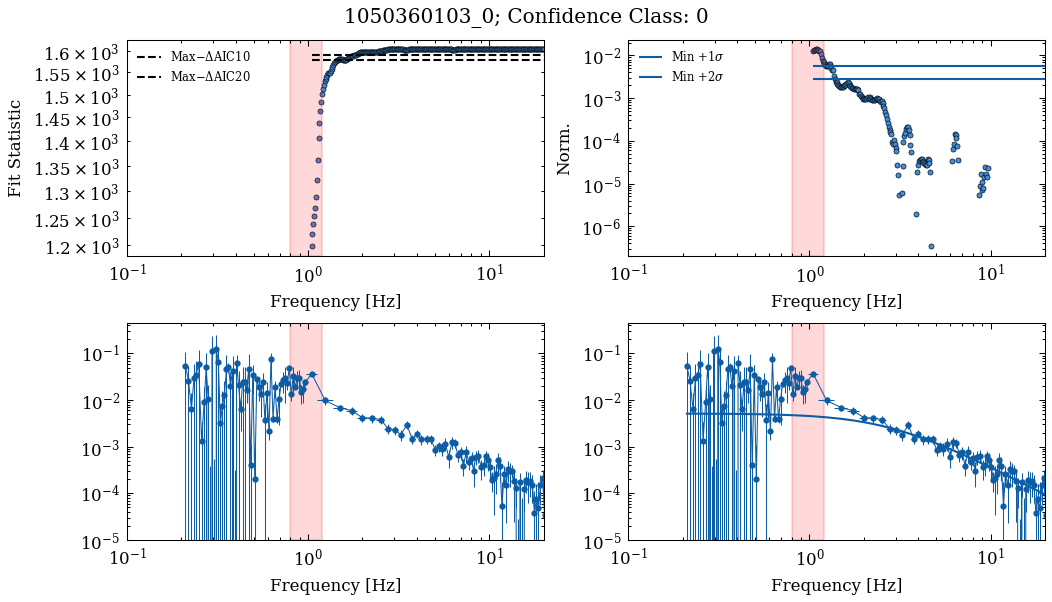

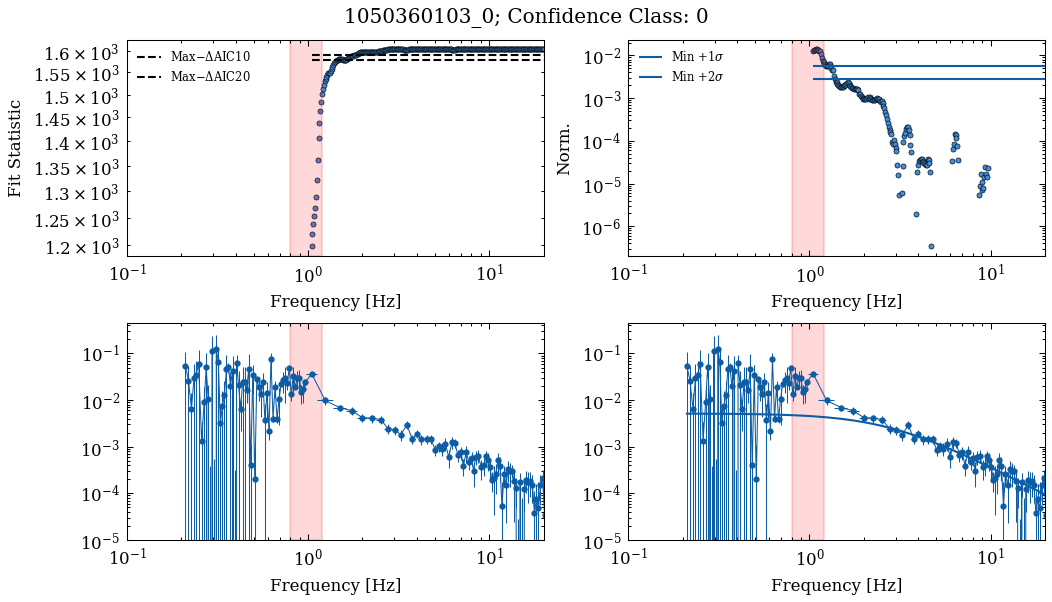

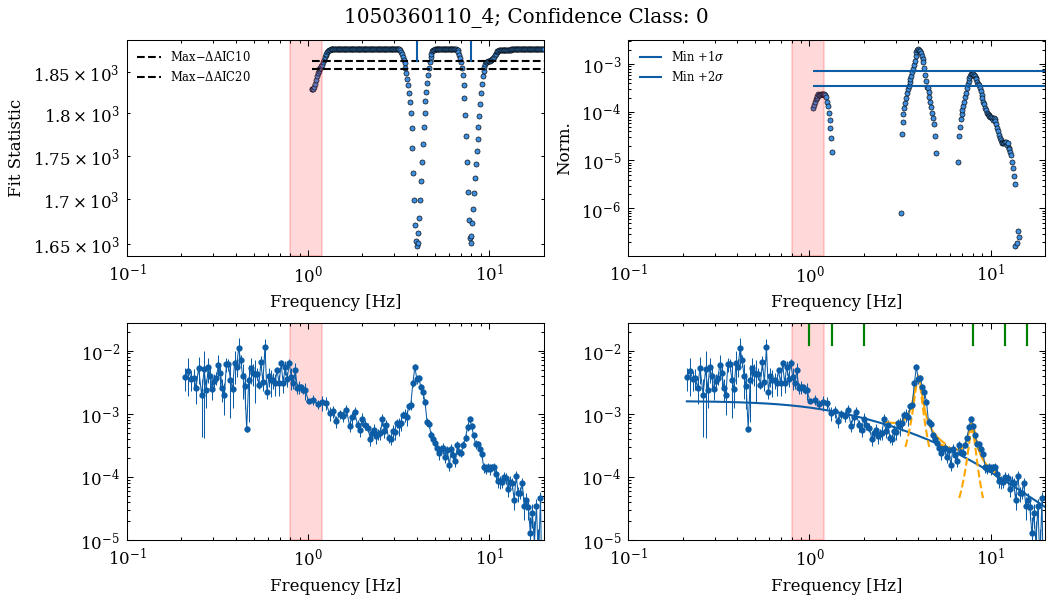

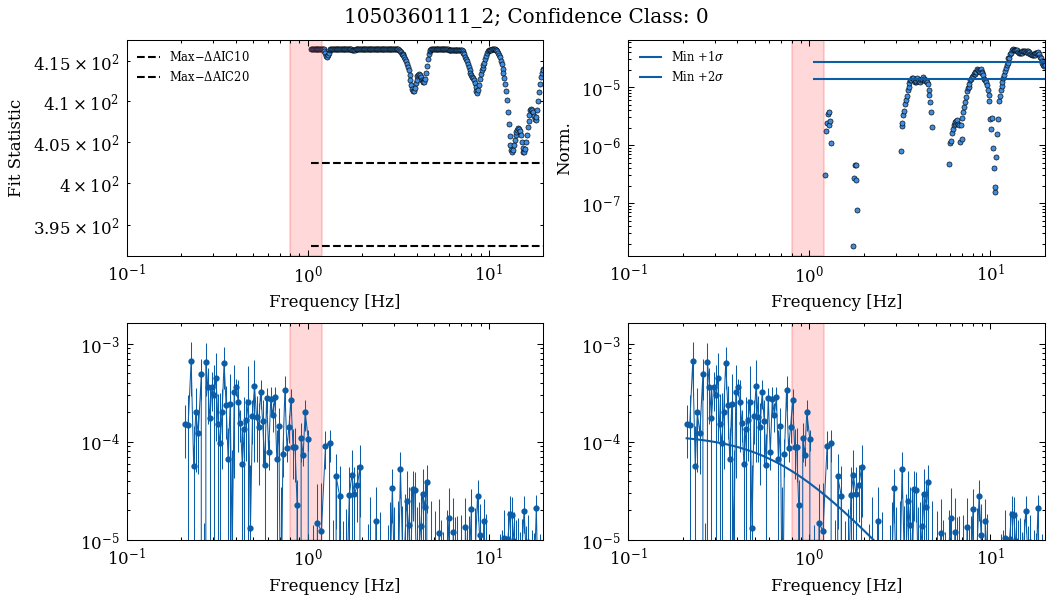

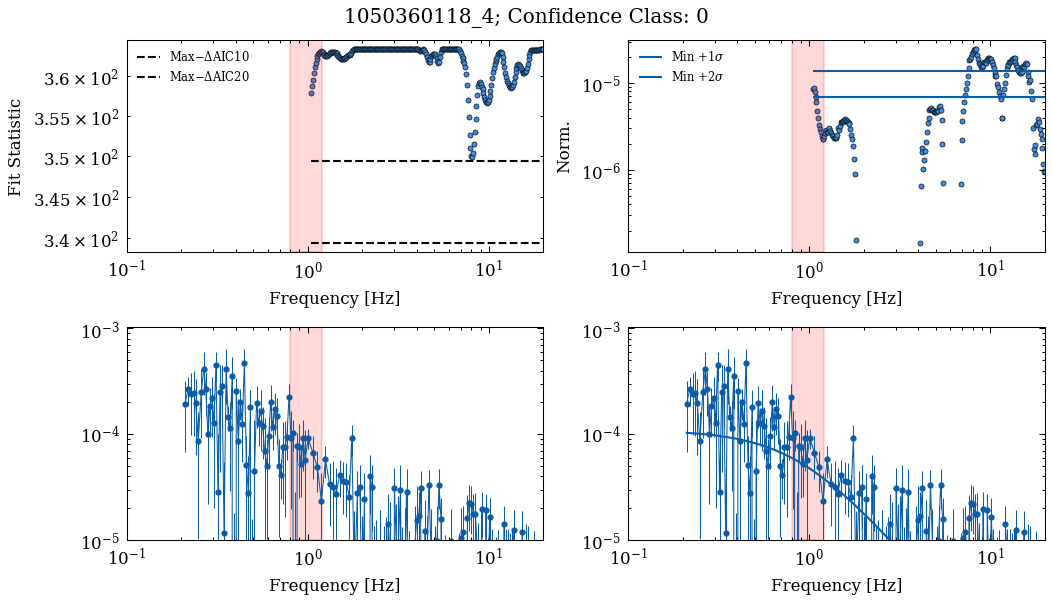

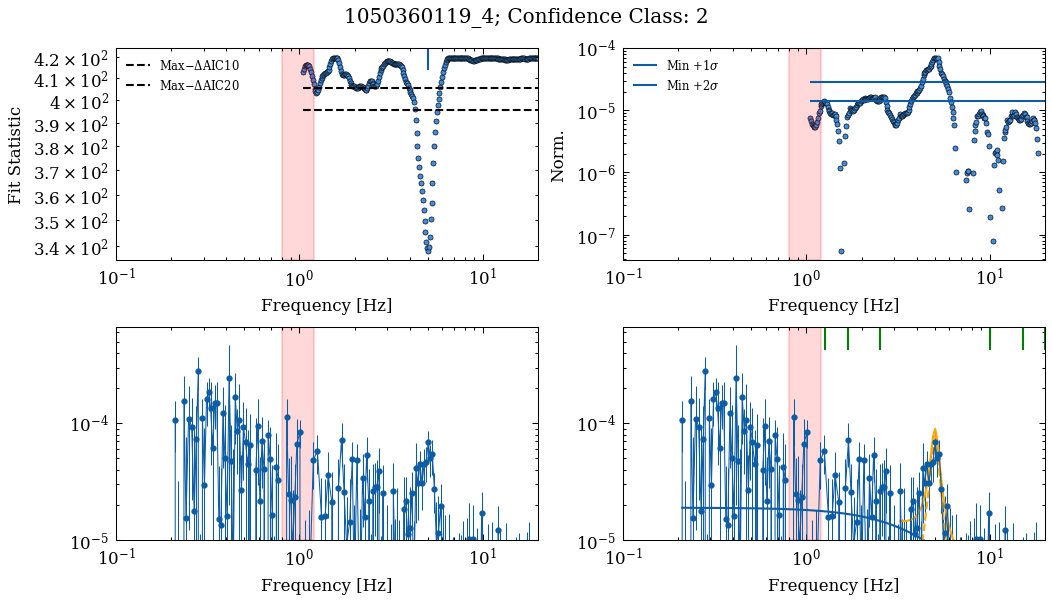

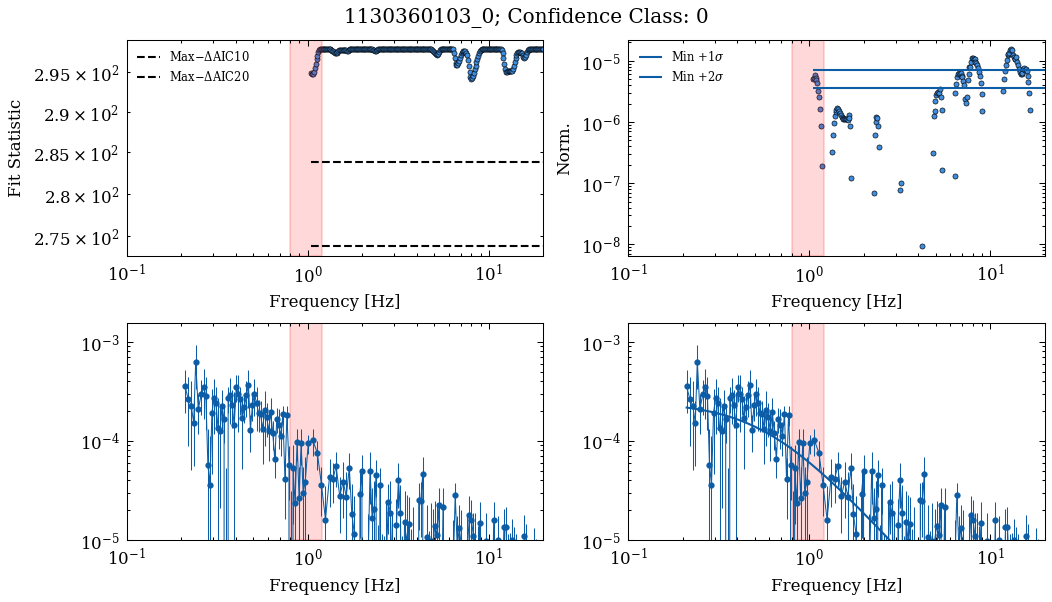

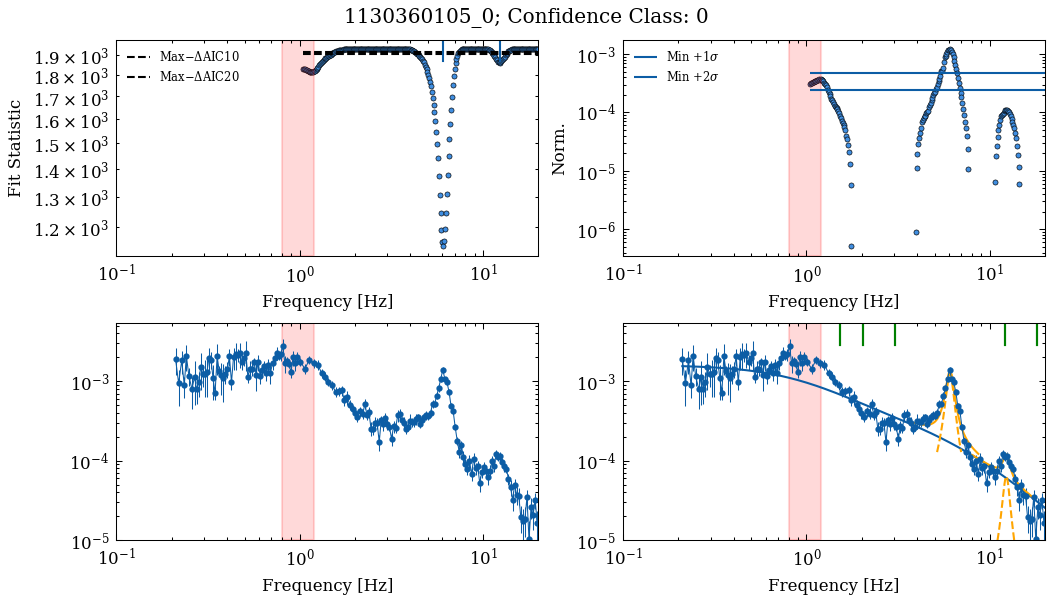

In [82]:
for id in bad_ids: 
    display(get_plot(id))

### svr?

In [104]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

# Train/test split

non_zero_qpos = np.logical_and(qpo_df['num_qpos']>0, True)
rs = 6
X_train, X_test, y_train, y_test, non_zero_qpos_train, non_zero_qpos_test = train_test_split(x_vals[train_mask], y_vals[train_mask], non_zero_qpos[train_mask], test_size=0.1, random_state=rs)

[[0.23344032 0.32646254 0.        ]
 [0.22696941 0.29694662 0.        ]
 [0.23054383 0.31057074 0.        ]
 [0.40206359 0.44588559 0.        ]
 [0.23492667 0.33602929 0.        ]
 [0.22537477 0.28025422 0.        ]]


[Text(0, 0.5, 'Predicted Frequency'), Text(0.5, 0, 'True Frequency')]

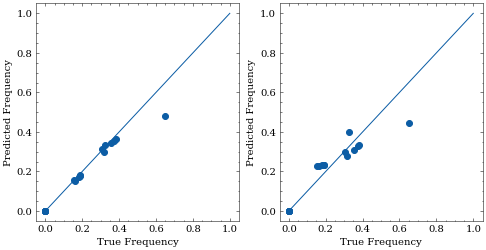

In [107]:
regr = RandomForestRegressor()
regr.fit(X_train,y_train)

regr.score(X_train, y_train)

fig, axs = plt.subplots(1, 2, figsize=(8,4))

predictions = regr.predict(X_test)

ax = axs[0]

ax.scatter(y_test[non_zero_qpos_test], predictions[non_zero_qpos_test])
ax.plot((0,1), (0,1))

ax.set(xlabel='True Frequency', ylabel='Predicted Frequency')

from sklearn import linear_model

svr = SVR()
regr = MultiOutputRegressor(svr)
reg = linear_model.BayesianRidge()

regr = regr.fit(X_train[non_zero_qpos_train], y_train[non_zero_qpos_train])

y_pred = regr.predict(X_test[non_zero_qpos_test])

print(y_pred)

ax = axs[1]

ax.scatter(y_test[non_zero_qpos_test], y_pred)
ax.plot((0,1), (0,1))

ax.set(xlabel='True Frequency', ylabel='Predicted Frequency')

## train check all for xspec data

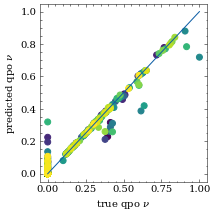

In [111]:
rs = 8

qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/new_current_qpos.csv')

mask = np.where(np.isfinite(qpo_df['num_qpos']))
qpo_df = qpo_df.iloc[mask]

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/wrangled_nthcomp_spectral_data.csv')

merged_df = qpo_df.merge(spectral_df, left_on='full_id', right_on='full_ids').sample(frac=1, random_state=rs)
merged_df = merged_df.fillna(0)


confidences = np.array(merged_df['confidence_class'])
mask = np.logical_and(confidences<7, confidences>=0)
merged_df = merged_df.iloc[mask] 


# x values
x_vals = np.array([], dtype=float).reshape(0,5) 
arr_names =  ['hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error', 'nthcomp_norm_before_error', 'net_source_count_rate'] #reduced_fit_stat
(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts) = (normalize(np.array(merged_df[arr_name])) for arr_name in arr_names)

for a, b, c, d, e, in zip(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e)])
    x_vals = np.vstack([x_vals, new_arr])


# just checking for multicolinearity solution help --> doesn't help let's go 

# y values 
# normalize all freqs according to same function ---- THIS IS SO MESSY I KNOW...I AM SORRY 
combined_freqs = np.concatenate((merged_df['first_freq'], merged_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((merged_df['first_width'], merged_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((merged_df['first_norm'], merged_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']
freq1s, freq2s = (norm(np.array(merged_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names[0:2])
width1s, width2s = (norm(np.array(merged_df[arr_name]), min_width, max_width) for arr_name in y_col_names[2:4])
norm1s, norm2s = (norm(np.array(merged_df[arr_name]), min_norm, max_norm) for arr_name in y_col_names[4:])

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], width1s[i], width2s[i], norm1s[i], norm2s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)
X_train, X_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.1, shuffle=True, random_state=rs)
# Random Forest on spectral inputs 

X_train = x_vals
X_test = x_vals

y_train = y_vals

y_test = y_vals

regr = RandomForestRegressor()
regr.fit(X_train,y_train)

predictions = regr.predict(X_test)
predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])
predicted_widths = np.array([predictions[i][2:4] for i in range(len(predictions))])
predicted_norms = np.array([predictions[i][4:] for i in range(len(predictions))])

test_freqs = np.array([y_test[i][0:2] for i in range(len(y_test))])
test_widths = np.array([predictions[i][2:4] for i in range(len(y_test))])
test_norms = np.array([predictions[i][4:] for i in range(len(y_test))])

mses = [mse_score(test_freqs, predicted_freqs), mse_score(test_widths, predicted_widths), mse_score(test_norms, predicted_norms)]
maes = [mae_score(test_freqs, predicted_freqs), mae_score(test_widths, predicted_widths), mae_score(test_norms, predicted_norms)]
rsqs = [r2_score(test_freqs, predicted_freqs), r2_score(test_widths, predicted_widths), r2_score(test_norms, predicted_norms)]
fig, ax = plt.subplots(figsize=(3,3))
fig.tight_layout()

colors = np.sort(2*list(range(len(predictions))))

ax.scatter(test_freqs, predicted_freqs, c=colors)
ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')

ax.plot([0,1], [0,1])    
plt.show()